In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import time
plt.style.use('seaborn')
% matplotlib inline

In [2]:
path = 'c:\\users\\ambro\\desktop\\AudioClassifier\\UrbanSound8k'
df = pd.read_csv(path+"\\metadata\\UrbanSound8k.csv") # metadata csv

## Data Exploration

In [3]:
df.head(20)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
slice_file_name    8732 non-null object
fsID               8732 non-null int64
start              8732 non-null float64
end                8732 non-null float64
salience           8732 non-null int64
fold               8732 non-null int64
classID            8732 non-null int64
class              8732 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 545.8+ KB


In [5]:
df['class'].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

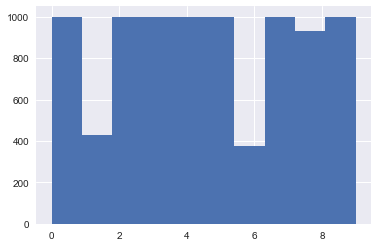

In [6]:
df['classID'].hist()

slice_file_name    1798
fsID               1798
start              1798
end                1798
salience           1798
fold               1798
classID            1798
class              1798
length             1798
dtype: int64


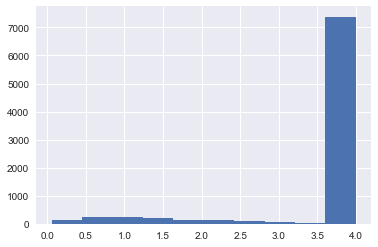

In [7]:
df['length'] = df['end'] - df['start']
df['length'].hist()
print(df[df.length < 4.0].count())

Roughly 20% of examples have length less than 4 seconds. We can't discard these examples, since there is already a paucity of data. We will have treat these less-than-ideal data somehow (by zero-padding, or allternately, by periodically extending the data to reach the desired length). Furthermore, there are relatively fewer examples of class 1(?) and 6, thus we anticipate poorer performance on these classes, than other classes, since there are fewer examples to learn from.

In [20]:
# Some helper functions
def normalize(input_file, amp=1):
    """
    Normalizes input_file so the maximum amplitude is +amp or -amp.
    """
    max_amp = np.amax(np.abs(input_file))
    return amp * (input_file / max_amp)

def get_mel_spectrogram(x, sampling_rate, num_mel_bands, window_size, hop_length):
    """
    Returns mel spectrogram of input x, given sampling_rate, num_mel_bands, window_size, hop_length
    """
    out = librosa.feature.melspectrogram(x, sampling_rate , n_fft=window_size, 
                                         hop_length=hop_length, n_mels=num_mel_bands, power=2)
    ref = np.amax(out)
    spectrogram_in_db = librosa.power_to_db((out), ref=ref)
    return spectrogram_in_db

def zero_pad(input_file, desired_length):
    """
    Returns a zero-padded version of input_file, so all examples have the same length"""
    u = np.zeros(int(desired_length - len(input_file)))
    return np.concatenate((input_file, u), axis=0)

### Inspection and visualization

Computation time is: 0.27526 seconds


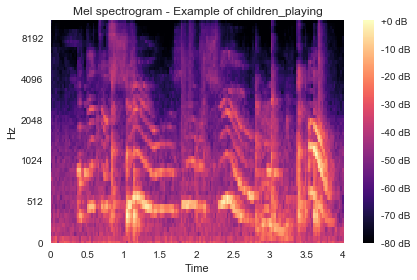

In [129]:
# Some user-defined parameters. Mostly an arbitrary choice for the first attempt at this
sampling_rate_new = 22050   # sampling rate to resample audio files to (in Hz)
mel_bands = 60              # mel frequency bands to extract
window_size = 1024          # for the STFT window (in samples)
hop_length = 512            # for the STFT (in samples)
desired_length = 88200

idx = np.random.randint(0, df.shape[0])
fold = df.iloc[idx]['fold'] # extract fold number
label = df.iloc[idx]['class'] # extract class name
file = df.iloc[idx]['slice_file_name'] # extract file name

start = time.time() # for measuring performance of basic processing task
y, sr = librosa.load(path+"\\audio\\fold"+str(fold)+"\\"+str(file), sr=sampling_rate_new)
x = normalize(y)
if len(x) < desired_length:
    x = zero_pad(x, desired_length)
X = get_mel_spectrogram(x, sampling_rate_new, mel_bands, window_size, hop_length)
end = time.time()
print("Computation time is: {:.5} seconds".format(end - start))

librosa.display.specshow(X, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram - Example of {}'.format(label))
plt.tight_layout()

 Computation time $\approx 0.5 \text{ sec/example} * 8800 \text{ examples} \approx 1.25$ hours to process all the examples

## Preprocessing

In [36]:
# build train/test data
N = df.shape[0]
X = np.zeros((N, 60, 173)) # data
Y = np.zeros(N) # labels

for idx in range(N):
    fold = df.iloc[idx]['fold']
    label = df.iloc[idx]['classID']
    file = df.iloc[idx]['slice_file_name']
    os.chdir(path+"\\audio\\fold"+str(fold))
    data, _ = librosa.load(path+"\\audio\\fold"+str(fold)+"\\"+str(file), sr=sampling_rate_new)
    # zero pad is the signal is shorter than 4 sec
    if len(data) < desired_length:
        data = zero_pad(data, desired_length)
    data_normalized = normalize(data) # normalize
    S = get_mel_spectrogram(data_normalized, sampling_rate_new, mel_bands, window_size, hop_length)
    X[idx,:,:] = S[:60, :173]
    Y[idx] = label
    # some nice progress messages ...
    if idx % 500 == 0:
        print("{:.2f}% done".format(idx*100 / N))

0.00% done
5.73% done
11.45% done
17.18% done
22.90% done
28.63% done
34.36% done
40.08% done
45.81% done
51.53% done
57.26% done
62.99% done
68.71% done
74.44% done
80.16% done
85.89% done
91.62% done
97.34% done


### Train/test split &One-Hot Encoding

In [37]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [71]:
# One-Hot Encoding
data = np.array(Y)
Ybar = to_categorical(data)

# Train/test split
split = 0.20 # 20% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X, Ybar, test_size=split, random_state=42)

In [39]:
X_train[0].shape

(60, 173)

In [72]:
# Reshape data to play nicely with Keras
X_train = np.asarray(X_train)
X_train = np.expand_dims(X_train, axis=3)
X_test = np.asarray(X_test)
X_test = np.expand_dims(X_test, axis=3)
np.reshape(X_train, (-1, 60, 173, 1))
np.reshape(X_test, (-1, 60, 173, 1))

# check
print("The shape of X_train is: {}".format(X_train.shape))
print("The shape of X_test is: {}".format(X_test.shape))
print("The shape of y_train is: {}".format(y_train.shape))
print("The shape of y_test is: {}".format(y_test.shape))

The shape of X_train is: (6985, 60, 173, 1)
The shape of X_test is: (1747, 60, 173, 1)
The shape of y_train is: (6985, 10)
The shape of y_test is: (1747, 10)


## CNN

In [73]:
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, ZeroPadding2D, Dropout, Flatten, Input, Activation
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
import tensorflow as tf

In [74]:
# CNN Architecture: Version 1
def model(input_shape=(60,173,1), classes=10):
    
    # Input placeholder
    X_input = Input(input_shape)
    
    # Conv2D -> BN -> ReLU -> maxpool -> Dropout block applied 2 times
    X = Conv2D(16, (3,3), padding='same', strides=(1,1), name='Conv1')(X_input)
    X = BatchNormalization(axis=3, name='BN1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool1')(X)
    X = Dropout(0.1, name='Dropout1')(X)
    
    X = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='Conv2')(X)
    X = BatchNormalization(axis=3, name='BN2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), name='max_pool2')(X)
    X = Dropout(0.1, name='Dropout2')(X)

    X = Flatten()(X)
    
    # Fully connected layers
    X = Dense(25, activation='relu', name='FC1')(X)
    X = Dense(classes, activation='softmax', name='FC2')(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name='CNN_MODEL1')
    
    return model

In [75]:
# Compile model, check summary, etc.
model = model()
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 60, 173, 1)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 60, 173, 16)       160       
_________________________________________________________________
BN1 (BatchNormalization)     (None, 60, 173, 16)       64        
_________________________________________________________________
activation_11 (Activation)   (None, 60, 173, 16)       0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 30, 86, 16)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 30, 86, 16)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 30, 86, 64)        9280      
__________

In [76]:
history = model.fit(x=X_train, y=y_train, validation_split=0.2, 
                batch_size=100, epochs=10, verbose=1)

Train on 5588 samples, validate on 1397 samples
Epoch 1/10
5588/5588 [==============================] - 414s 74ms/step - loss: 5.1087 - acc: 0.1994 - val_loss: 2.2261 - val_acc: 0.1346
Epoch 2/10
5588/5588 [==============================] - 409s 73ms/step - loss: 2.1287 - acc: 0.1967 - val_loss: 2.1477 - val_acc: 0.1482
Epoch 3/10
5588/5588 [==============================] - 407s 73ms/step - loss: 2.0098 - acc: 0.2385 - val_loss: 2.5500 - val_acc: 0.2455
Epoch 4/10
5588/5588 [==============================] - 416s 74ms/step - loss: 1.9635 - acc: 0.2915 - val_loss: 2.7250 - val_acc: 0.2505
Epoch 5/10
5588/5588 [==============================] - 416s 74ms/step - loss: 1.9205 - acc: 0.3101 - val_loss: 2.1765 - val_acc: 0.2863
Epoch 6/10
5588/5588 [==============================] - 423s 76ms/step - loss: 1.8585 - acc: 0.3273 - val_loss: 1.9738 - val_acc: 0.3092
Epoch 7/10
5588/5588 [==============================] - 406s 73ms/step - loss: 1.8115 - acc: 0.3388 - val_loss: 2.0736 - val_acc: 

- First, we failed to normalize the data. So we *must* address that.
- Second, the training and validation accuracy is not impressive (current state of the art is in the low 70s). Further, the validation accuracy is significantly less than the training accuracy, suggesting that we are underfitting, i.e., we need a more complicated/expressive model. This can be accomplished in numerous ways. We will add an additional convolutional layer and increase the width of the fully connected layer. This result is somewhat suprising given how small the training data is.
- Lastly, we will use a better initilization scheme (namely, Glorot Uniform aka Xavier) for the weights of the fully connected layers.

In [92]:
# Normalize test and traing data to have mean = 0, variance = 1
mean = np.mean(X_train)
std = np.std(X_train)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [93]:
# CNN Arhitecture: Verson 2

def model2(input_shape=(60,173,1), classes=10):
    
    # Input placeholder
    X_input = Input(input_shape)
    
    # Conv2D -> BN -> ReLU -> maxpool -> Dropout block applied 3 times
    X = Conv2D(24, (5,5), padding='same', strides=(1,1), name='Conv1')(X_input)
    X = BatchNormalization(axis=3, name='BN1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool1')(X)
    X = Dropout(0.1, name='Dropout1')(X)
    
    X = Conv2D(48, (3, 3), strides=(1, 1), padding='same', name='Conv2')(X)
    X = BatchNormalization(axis=3, name='BN2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), name='max_pool2')(X)
    X = Dropout(0.1, name='Dropout2')(X)

    X = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='Conv3')(X)
    X = BatchNormalization(axis=3, name='BN3')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), name='max_pool3')(X)
    X = Dropout(0.1, name='Dropout3')(X)
    
    X = Flatten()(X)
    
    # Fully connected layers
    X = Dense(100, activation='relu', kernel_initializer='glorot_uniform', name='FC1')(X)
    X = Dense(classes, activation='softmax', kernel_initializer='glorot_uniform', name='FC2')(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name='CNN_MODEL2')
    
    return model

In [94]:
model2 = model2()
model2.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 60, 173, 1)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 60, 173, 24)       624       
_________________________________________________________________
BN1 (BatchNormalization)     (None, 60, 173, 24)       96        
_________________________________________________________________
activation_31 (Activation)   (None, 60, 173, 24)       0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 30, 86, 24)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 30, 86, 24)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 30, 86, 48)        10416     
__________

In [95]:
history = model2.fit(x=X_train, y=y_train, validation_split=0.2, 
                batch_size=100, epochs=10, verbose=1)

Train on 5588 samples, validate on 1397 samples
Epoch 1/10
5588/5588 [==============================] - 531s 95ms/step - loss: 4.3835 - acc: 0.3731 - val_loss: 3.2242 - val_acc: 0.4767
Epoch 2/10
5588/5588 [==============================] - 528s 94ms/step - loss: 3.1811 - acc: 0.5011 - val_loss: 1.9335 - val_acc: 0.4710
Epoch 3/10
5588/5588 [==============================] - 529s 95ms/step - loss: 1.4589 - acc: 0.5481 - val_loss: 1.4687 - val_acc: 0.4524
Epoch 4/10
5588/5588 [==============================] - 525s 94ms/step - loss: 0.9739 - acc: 0.6662 - val_loss: 1.4317 - val_acc: 0.4868
Epoch 5/10
5588/5588 [==============================] - 521s 93ms/step - loss: 0.8430 - acc: 0.7139 - val_loss: 1.5603 - val_acc: 0.4911
Epoch 6/10
5588/5588 [==============================] - 515s 92ms/step - loss: 0.7229 - acc: 0.7504 - val_loss: 1.2211 - val_acc: 0.5705
Epoch 7/10
5588/5588 [==============================] - 517s 93ms/step - loss: 0.6193 - acc: 0.7895 - val_loss: 1.0574 - val_acc: 

- Huge improvement over last run
- Training accuracy is still low. The accuracy jump epoch-to-epoch suggests more training epochs are needed.
- validation accuracy significantly lower than training accuracy, suggesting the need for more regularization (increase dropout)
- Also increase rate of Adam optimizer from 0.001 to 0.01 per suggestions found online 

In [96]:
# CNN Arhitecture: Verson 3

def model3(input_shape=(60,173,1), classes=10):
    
    # Input placeholder
    X_input = Input(input_shape)
    
    # Conv2D -> BN -> ReLU -> maxpool -> Dropout block applied 3 times
    X = Conv2D(24, (5,5), padding='same', strides=(1,1), name='Conv1')(X_input)
    X = BatchNormalization(axis=3, name='BN1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool1')(X)
    X = Dropout(0.15, name='Dropout1')(X)
    
    X = Conv2D(48, (3, 3), strides=(1, 1), padding='same', name='Conv2')(X)
    X = BatchNormalization(axis=3, name='BN2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), name='max_pool2')(X)
    X = Dropout(0.15, name='Dropout2')(X)

    X = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='Conv3')(X)
    X = BatchNormalization(axis=3, name='BN3')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), name='max_pool3')(X)
    X = Dropout(0.15, name='Dropout3')(X)
    
    X = Flatten()(X)
    
    # Fully connected layers
    X = Dense(100, activation='relu', kernel_initializer='glorot_uniform', name='FC1')(X)
    X = Dense(classes, activation='softmax', kernel_initializer='glorot_uniform', name='FC2')(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name='CNN_MODEL3')
    
    return model

In [97]:
model3 = model3()
model3.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.01), metrics=["accuracy"])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 60, 173, 1)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 60, 173, 24)       624       
_________________________________________________________________
BN1 (BatchNormalization)     (None, 60, 173, 24)       96        
_________________________________________________________________
activation_34 (Activation)   (None, 60, 173, 24)       0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 30, 86, 24)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 30, 86, 24)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 30, 86, 48)        10416     
__________

In [98]:
history3 = model3.fit(x=X_train, y=y_train, validation_split=0.2, 
                batch_size=100, epochs=20, verbose=1)

Train on 5588 samples, validate on 1397 samples
Epoch 1/20
5588/5588 [==============================] - 532s 95ms/step - loss: 14.1611 - acc: 0.1081 - val_loss: 14.3182 - val_acc: 0.1117
Epoch 2/20
5588/5588 [==============================] - 531s 95ms/step - loss: 14.3644 - acc: 0.1088 - val_loss: 14.3182 - val_acc: 0.1117
Epoch 3/20
5588/5588 [==============================] - 529s 95ms/step - loss: 14.3644 - acc: 0.1088 - val_loss: 14.3182 - val_acc: 0.1117
Epoch 4/20


KeyboardInterrupt: 

- CNN is not learning (after 3 epochs, still at 10% accuracy)
- Adjust learning rate back to original value ...
- Set number of epochs to 15

In [102]:
# CNN Arhitecture: Verson 4

def model4(input_shape=(60,173,1), classes=10):
    
    # Input placeholder
    X_input = Input(input_shape)
    
    # Conv2D -> BN -> ReLU -> maxpool -> Dropout block applied 3 times
    X = Conv2D(24, (5,5), padding='same', strides=(1,1), name='Conv1')(X_input)
    X = BatchNormalization(axis=3, name='BN1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool1')(X)
    X = Dropout(0.15, name='Dropout1')(X)
    
    X = Conv2D(48, (3, 3), strides=(1, 1), padding='same', name='Conv2')(X)
    X = BatchNormalization(axis=3, name='BN2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), name='max_pool2')(X)
    X = Dropout(0.15, name='Dropout2')(X)

    X = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='Conv3')(X)
    X = BatchNormalization(axis=3, name='BN3')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), name='max_pool3')(X)
    X = Dropout(0.15, name='Dropout3')(X)
    
    X = Flatten()(X)
    
    # Fully connected layers
    X = Dense(100, activation='relu', kernel_initializer='glorot_uniform', name='FC1')(X)
    X = Dense(classes, activation='softmax', kernel_initializer='glorot_uniform', name='FC2')(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name='CNN_MODEL4')
    
    return model

In [103]:
model4 = model4()
model4.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 60, 173, 1)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 60, 173, 24)       624       
_________________________________________________________________
BN1 (BatchNormalization)     (None, 60, 173, 24)       96        
_________________________________________________________________
activation_40 (Activation)   (None, 60, 173, 24)       0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 30, 86, 24)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 30, 86, 24)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 30, 86, 48)        10416     
__________

In [105]:
history4 = model4.fit(x=X_train, y=y_train, validation_split=0.2, 
                batch_size=100, epochs=15, verbose=1)

Train on 5588 samples, validate on 1397 samples
Epoch 1/15
5588/5588 [==============================] - 530s 95ms/step - loss: 4.5242 - acc: 0.3275 - val_loss: 4.5552 - val_acc: 0.3801
Epoch 2/15
5588/5588 [==============================] - 524s 94ms/step - loss: 3.5424 - acc: 0.4885 - val_loss: 3.9208 - val_acc: 0.4961
Epoch 3/15
5588/5588 [==============================] - 524s 94ms/step - loss: 3.2913 - acc: 0.5682 - val_loss: 3.8358 - val_acc: 0.5197
Epoch 4/15
5588/5588 [==============================] - 525s 94ms/step - loss: 3.1991 - acc: 0.6142 - val_loss: 3.7470 - val_acc: 0.5619
Epoch 5/15
5588/5588 [==============================] - 529s 95ms/step - loss: 3.0633 - acc: 0.6566 - val_loss: 3.7124 - val_acc: 0.5648
Epoch 6/15
5588/5588 [==============================] - 527s 94ms/step - loss: 3.0194 - acc: 0.6709 - val_loss: 3.8949 - val_acc: 0.5190
Epoch 7/15
5588/5588 [==============================] - 524s 94ms/step - loss: 2.9664 - acc: 0.6906 - val_loss: 3.7935 - val_acc: 

In [106]:
## Test Model 4
test_score = model4.evaluate(X_test, y_test, verbose=1)
test_score, test_accuracy = test_score
print("Test error: {}".format(test_score))
print("Test accuracy: {}".format(test_accuracy))

1747/1747 [==============================] - 77s 44ms/step
Test error: 2.9962883530580187
Test accuracy: 0.7240984548004818


72% test accuracy! Not bad! As stated above, low to mid 70s is a good result for this dataset using this technique.

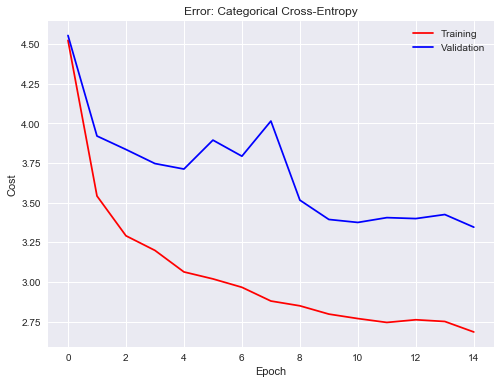

In [107]:
fig, ax = plt.subplots(figsize=(8,6))    
ax.plot(history4.history["loss"], c="r")
ax.plot(history4.history["val_loss"], c="b")
ax.set_title("Error: Categorical Cross-Entropy")
ax.set_ylabel("Cost")
ax.set_xlabel("Epoch")
ax.legend(["Training", "Validation"], loc="best");